In [1]:
import os
import shutil

import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, product

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from keras import layers, Model, ops
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
data_path = "/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset"
genuine_signatures, forged_signatures = {}, {}

for dataset in os.listdir(data_path):
    dataset_path = os.path.join(data_path, dataset)

    if dataset == "dataset4":
        real_path = os.path.join(dataset_path, "real1")
    else:
        real_path = os.path.join(dataset_path, "real")

    forge_path = os.path.join(dataset_path, "forge")
    for file in os.listdir(real_path):
        if not file.lower().endswith((".png", ".jpg", ".jpeg")):
            print(f"Warning: this image format is not supported => {file}")
            continue

        filename = os.path.splitext(file)[0]

        writer_id = filename[0:3]
        signer_id = filename[len(filename)-3::]

        if writer_id != signer_id:
            print(f"Warning: Inconsistent IDs in genuine signature {file}")
            continue

        if signer_id not in genuine_signatures:
            genuine_signatures[signer_id] = []
        img_path = os.path.join(real_path, file)
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (224, 224))
        img = np.array(img, dtype='float32') / 255
        genuine_signatures[signer_id].append(img)

    for file in os.listdir(forge_path):
        if not file.lower().endswith((".png", ".jpg", ".jpeg")):
            print(f"Warning: this image format is not supported => {file}")
            continue

        filename = os.path.splitext(file)[0]

        writer_id = filename[0:3]
        signer_id = filename[len(filename)-3::]

        if writer_id == signer_id:
            print(f"Warning: Forged signature {file} has same Writer and Signer IDs.")
            continue

        if signer_id not in forged_signatures:
            forged_signatures[signer_id] = []
        img_path = os.path.join(forge_path, file)
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (224, 224))
        img = np.array(img, dtype='float32') / 255
        forged_signatures[signer_id].append(img)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [3]:
genuine_count = sum(len(imgs) for imgs in genuine_signatures.values())
forged_count = sum(len(imgs) for imgs in forged_signatures.values())

print(f"Total Genuine Images: {genuine_count}")
print(f"Total Forged Images: {forged_count}")

Total Genuine Images: 360
Total Forged Images: 360


In [4]:
genuine_signatures["001"][0].shape

(224, 224)

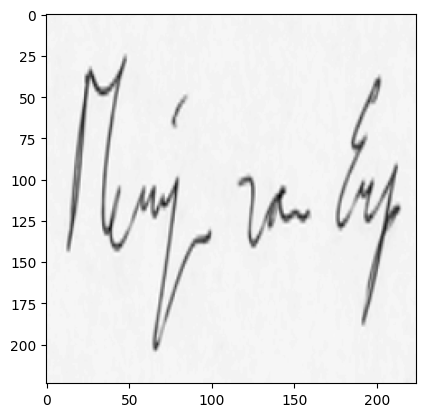

In [5]:
plt.imshow(genuine_signatures["001"][0], cmap="gray")

In [6]:
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [7]:
augmented_genuine_signatures = {}

for signer_id, images in genuine_signatures.items():
    augmented_genuine_signatures[signer_id] = []
    for img in images:
        img = img.reshape((1, 224, 224, 1))
        for augmented_img in datagen.flow(img, batch_size=1):
            augmented_genuine_signatures[signer_id].append(augmented_img[0].reshape((224, 224)))
            if len(augmented_genuine_signatures[signer_id]) >= 5:
                break

In [8]:
augmented_forged_signatures  = {}

for signer_id, images in forged_signatures.items():
    augmented_forged_signatures[signer_id] = []
    for img in images:
        img = img.reshape((1, 224, 224, 1))
        for augmented_img in datagen.flow(img, batch_size=1):
            augmented_forged_signatures[signer_id].append(augmented_img[0].reshape((224, 224)))
            if len(augmented_forged_signatures[signer_id]) >= 5:
                break

In [9]:
for signer_id, augmented_imgs in augmented_genuine_signatures.items():
    genuine_signatures[signer_id].extend(augmented_imgs)

for signer_id, augmented_imgs in augmented_forged_signatures.items():
    forged_signatures[signer_id].extend(augmented_imgs)

In [10]:
augmented_forged_signatures["001"][0].shape

(224, 224)

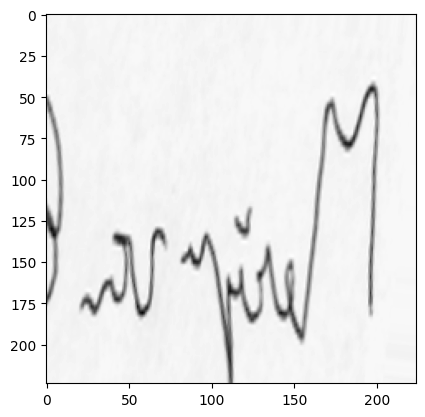

In [11]:
plt.imshow(augmented_forged_signatures["001"][0], cmap="gray")

In [12]:
augmented_genuine_count = sum(len(imgs) for imgs in genuine_signatures.values())
augmented_forged_count = sum(len(imgs) for imgs in forged_signatures.values())

print(f"Total Genuine Images before Augmentation ({genuine_count}),  after Augmentation ({augmented_genuine_count})")
print(f"Total Forged Images before Augmentation ({forged_count}),  after Augmentation ({augmented_forged_count})")

Total Genuine Images before Augmentation (360),  after Augmentation (896)
Total Forged Images before Augmentation (360),  after Augmentation (896)


In [13]:
positive_pairs = []
for signer, genuines in genuine_signatures.items():
    if len(genuines) < 2:
        continue
    positive_pairs.extend(combinations(genuines, 2))

In [14]:
print(len(positive_pairs))

10784


In [15]:
negative_pairs = []
for signer, genuines in genuine_signatures.items():
    forged = forged_signatures.get(signer, [])
    if not forged:
        continue
    for genuine in genuines:
        for f in forged:
            negative_pairs.append((genuine, f))

In [16]:
print(len(negative_pairs))

22464


In [17]:
num_positive = len(positive_pairs)
num_negative = len(negative_pairs)

if num_negative > num_positive:
    negative_pairs = random.sample(negative_pairs, num_positive)
elif num_negative < num_positive:
    add_negatives = random.choices(negative_pairs, k=num_positive - num_negative)
    negative_pairs.extend(add_negatives)

In [18]:
positive_labels = [1] * len(positive_pairs)
negative_labels = [0] * len(negative_pairs)

all_pairs = positive_pairs + negative_pairs
all_labels = positive_labels + negative_labels

combined = list(zip(all_pairs, all_labels))
random.shuffle(combined)
pairs_shuffled, labels_shuffled = zip(*combined)

train_ratio = 0.8
train_pairs, test_pairs, train_labels, test_labels = train_test_split(
    pairs_shuffled, labels_shuffled, train_size=train_ratio, random_state=42, stratify=labels_shuffled
)

train_pairs = np.array(train_pairs)
test_pairs = np.array(test_pairs)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_pairs_0 = train_pairs[:, 0].reshape(-1, 224, 224, 1)
train_pairs_1 = train_pairs[:, 1].reshape(-1, 224, 224, 1)
test_pairs_0 = test_pairs[:, 0].reshape(-1, 224, 224, 1)
test_pairs_1 = test_pairs[:, 1].reshape(-1, 224, 224, 1)

print(f"Training Pairs: {len(train_pairs)}, Testing Pairs: {len(test_pairs)}")

Training Pairs: 17254, Testing Pairs: 4314


In [19]:
train_pairs_0.shape

(17254, 224, 224, 1)

In [20]:
def manhattan_distance(vectors):
    x, y = vectors
    return tf.math.reduce_sum(tf.math.abs(x - y), axis=1, keepdims=True)

In [21]:
def siamese_model(input_shape, embedding_dim=128):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    pooledOutput = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(embedding_dim)(pooledOutput)
    model = Model(inputs, outputs)

    return model

In [22]:
def create_siamese_model(IMG_SHAPE, siamese_model, distance):
    imgA = layers.Input(shape=IMG_SHAPE)
    imgB = layers.Input(shape=IMG_SHAPE)

    featureExtractor = siamese_model(IMG_SHAPE)
    featsA = featureExtractor(imgA)
    featsB = featureExtractor(imgB)

    distance = layers.Lambda(distance)([featsA, featsB])

    outputs = layers.Dense(1, activation="sigmoid")(distance)

    model = Model(inputs=[imgA, imgB], outputs=outputs)
    return model

In [23]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return contrastive_loss

In [24]:
model = create_siamese_model((224, 224, 1), siamese_model, manhattan_distance)

In [25]:
BATCH_SIZE = 64
EPOCHS = 50
MARGIN = 1

model.compile(loss=loss(margin=MARGIN), optimizer="adam", metrics=["accuracy"])

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

callback_early_stop_reduceLROnPlateau=[earlyStopping, reduce_lr]

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128)       │     27,136 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,138 (106.01 KB)

 Trainable params: 27,138 (106.01 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    [train_pairs_0, train_pairs_1], train_labels,
    validation_data=([test_pairs_0, test_pairs_1], test_labels),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callback_early_stop_reduceLROnPlateau
)

Epoch 1/50


I0000 00:00:1734208900.124475     562 service.cc:145] XLA service 0x7b96f8006af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734208900.124539     562 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734208900.124544     562 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/270 ━━━━━━━━━━━━━━━━━━━━ 40:06 9s/step - accuracy: 0.4844 - loss: 0.2544

I0000 00:00:1734208907.671743     562 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


270/270 ━━━━━━━━━━━━━━━━━━━━ 49s 151ms/step - accuracy: 0.5214 - loss: 0.2494 - val_accuracy: 0.5366 - val_loss: 0.2471 - learning_rate: 0.0010
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.5442 - loss: 0.2464 - val_accuracy: 0.5779 - val_loss: 0.2423 - learning_rate: 0.0010
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - accuracy: 0.5771 - loss: 0.2430 - val_accuracy: 0.6069 - val_loss: 0.2390 - learning_rate: 0.0010
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 31s 116ms/step - accuracy: 0.5877 - loss: 0.2397 - val_accuracy: 0.5869 - val_loss: 0.2382 - learning_rate: 0.0010
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 31s 116ms/step - accuracy: 0.5851 - loss: 0.2383 - val_accuracy: 0.6050 - val_loss: 0.2350 - learning_rate: 0.0010
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - accuracy: 0.6017 - loss: 0.2360 - val_accuracy: 0.6041 - val_loss: 0.2328 - learning_rate: 0.0010
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 31s 116ms/step - accuracy: 0.6025 - loss:

In [27]:
predictions = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
predicted_labels = (predictions > 0.5).astype(int)

accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Accuracy: 0.7381
Precision: 0.7026
Recall: 0.8257
F1 Score: 0.7592


In [28]:
def plot_training(H):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

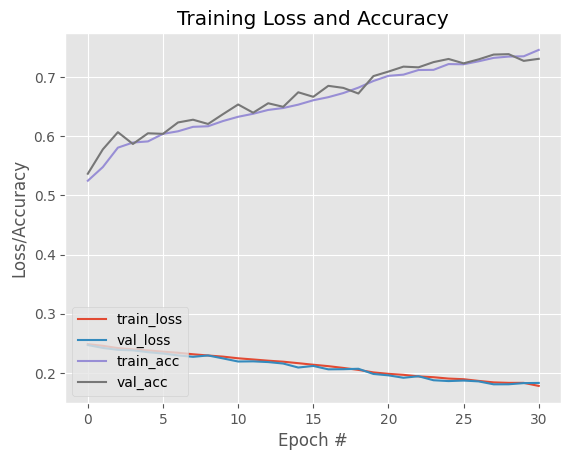

In [29]:
plot_training(history)

In [45]:
testing_path = "/kaggle/input/finaltest"

def load_img(photo_path):
    img = cv2.imread(photo_path, 0)
    img = cv2.resize(img, (224, 224))
    img = np.array(img, dtype='float32') / 255
    # img = img.reshape(224, 224, 1)
    return img

In [46]:
false_1 = load_img(testing_path+"/0.jpg")
false_2 = load_img(testing_path+"/00.jpg")

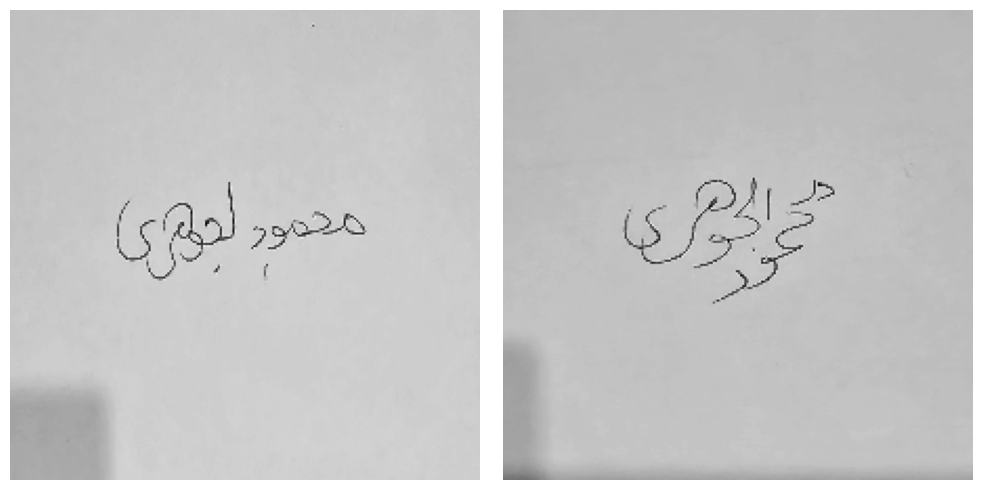

In [47]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(false_1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(false_2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [48]:
true_1 = load_img(testing_path+"/1.jpg")
true_2 = load_img(testing_path+"/11.jpg")

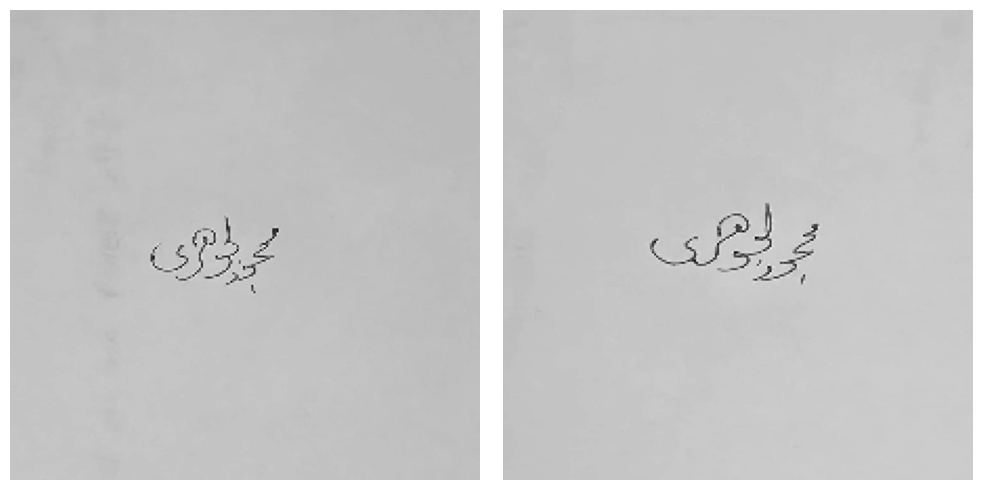

In [49]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(true_1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(true_2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [50]:
false_1 = np.expand_dims(false_1, axis=0)
false_2 = np.expand_dims(false_2, axis=0)

false_prediction = model.predict([false_1, false_2])

print("Prediction for false_1 and false_2:", false_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for false_1 and false_2: [[0.6253541]]


In [51]:
true_1 = np.expand_dims(true_1, axis=0)
true_2 = np.expand_dims(true_2, axis=0)

true_prediction = model.predict([true_1, true_2])

print("Prediction for true_1 and true_2:", true_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction for true_1 and true_2: [[0.77531993]]
